## 1. Preparation

In [1]:
import os, sys
sys.path.append(os.path.abspath('../'))

### Import modules

In [2]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from datetime import datetime


from storage import MongoDBStorageAdapter
from utils.tools import convert_to_str

## 2. Data fetching and preparation

In this section, our target is to get data and prepare them in the order to be visualized.

### 2.1. Fetch messages from MongoDB

Get raw messages

In [3]:
store = MongoDBStorageAdapter();

all_messages = store.get_all_msgs();

2019-11-16 18:48:35,454 - storage.models - INFO - Try to establish connection to MongoDB instance on mongodb:27017 as 'user' 


Flatten JSON into 2D table

In [4]:
from pandas.io.json import json_normalize

# Transform into flat JSON and make a DateFrame
df = json_normalize(all_messages)

# Make a reserve copy
res_df = df.copy()

Show columns

In [5]:
df.columns

Index(['_id', 'time', 'message_type', 'longitude', 'latitude', 'device.id',
       'device.device_type', 'payload.ssid', 'payload.bssid',
       'payload.signal.rssi'],
      dtype='object')

In [6]:
ap_names = df["payload.ssid"].unique()
metric_times = df['time'].unique()

### 2.2. Data Transforming

Transform data to required types

In [7]:
# using dictionary to convert specific columns 
convert_dict = {'longitude': float, 
                'latitude': float,
                'payload.signal.rssi': int,
               } 

df = df.astype(convert_dict) 

df["time"] = pd.to_datetime(df["time"])
df['time'] = df['time'].apply(lambda dt: datetime(dt.year, dt.month, dt.day, dt.hour,dt.minute,))

### 2.3. Data Filtering

Prepare filter for out data

In [8]:
only_handies = df["device.device_type"] == "handy"
has_wifi = df["message_type"] == 'wifi'

Clear out our dataset

In [9]:
only_handies_with_wifi_df = df[only_handies][has_wifi]

Select only necessary columns

In [10]:
wifi_signal_quality_df = only_handies_with_wifi_df[["time","longitude","latitude","device.id",'payload.signal.rssi',"payload.ssid"]]

In [11]:
wifi_signal_quality_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2839 entries, 0 to 2838
Data columns (total 6 columns):
time                   2839 non-null datetime64[ns]
longitude              2839 non-null float64
latitude               2839 non-null float64
device.id              2839 non-null object
payload.signal.rssi    2839 non-null int64
payload.ssid           2839 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 155.3+ KB


## 3. Visualization

In this section, we want to visualize our Wifi Quality Signal data with GPS location.

We target the following diagrams:

1. Mean signal quality estimation for AP  in Time.
2. Changes of GPS location for Client in Time.
3. Mean Estimated signal quality for AP per Location.

### 3.1. Mean signal quality estimation for AP  in Time.

2019-11-16 18:48:35,861 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


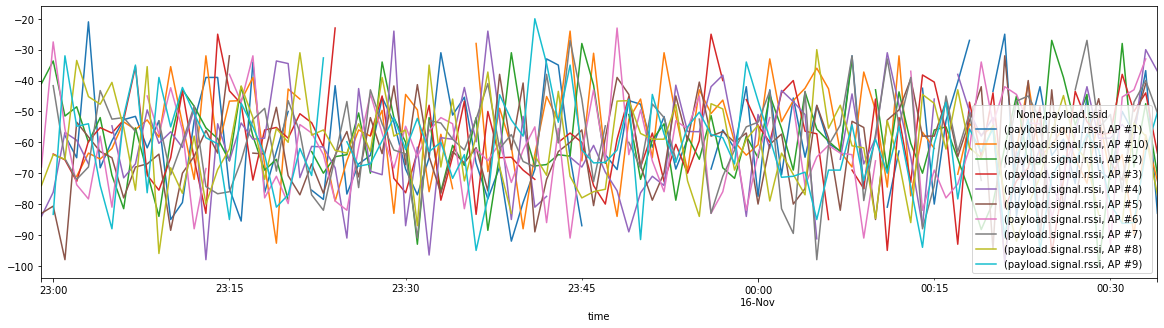

In [12]:
wifi_signal_quality_df[["payload.ssid","time","payload.signal.rssi"]].groupby(["time", "payload.ssid"]).mean().unstack().plot(figsize=(20,5))

In [13]:
grouped_ap_df = wifi_signal_quality_df.groupby(["payload.ssid",])

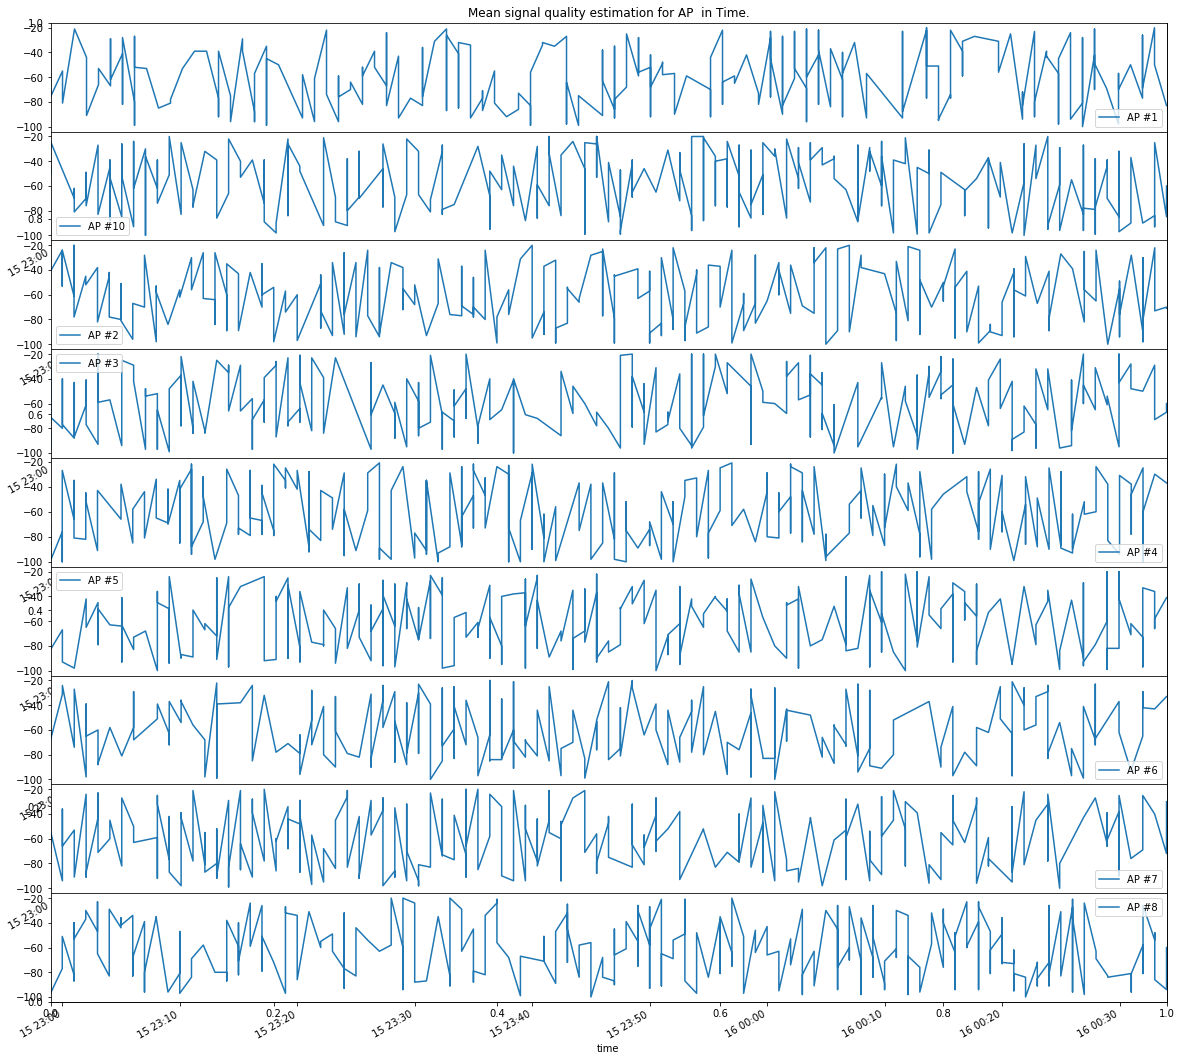

In [14]:
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(hspace=0)
plt.title("Mean signal quality estimation for AP  in Time.")

for index,(name, group) in zip(range(1,len(ap_names)),grouped_ap_df):
    
    ax = fig.add_subplot(len(ap_names)-1,1,index)

    group.plot(x="time", y="payload.signal.rssi",ax=ax);
    plt.legend([name])

### 3.2. Changes of GPS location for Client in Time.

In [87]:
def normalize_series(x):
    
    normalized = (x-min(x))/(max(x)-min(x))
    
    return normalized


normalize_series(wifi_signal_quality_df["payload.signal.rssi"])

0       0.3875
1       0.0125
2       0.6125
3       0.7375
4       0.4000
         ...  
2834    0.5000
2835    0.8125
2836    0.5000
2837    0.7500
2838    0.8750
Name: payload.signal.rssi, Length: 2839, dtype: float64

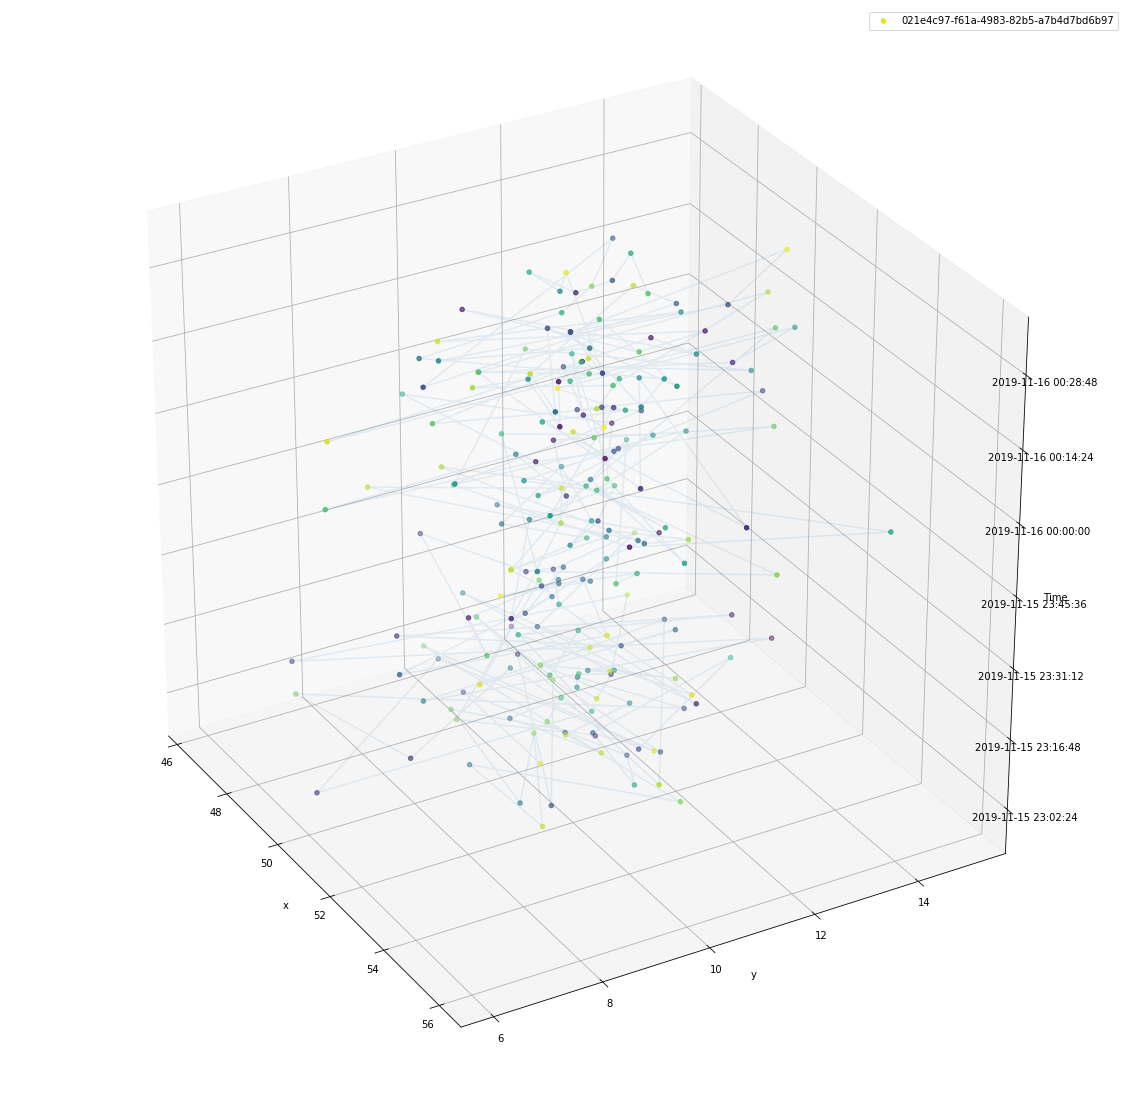

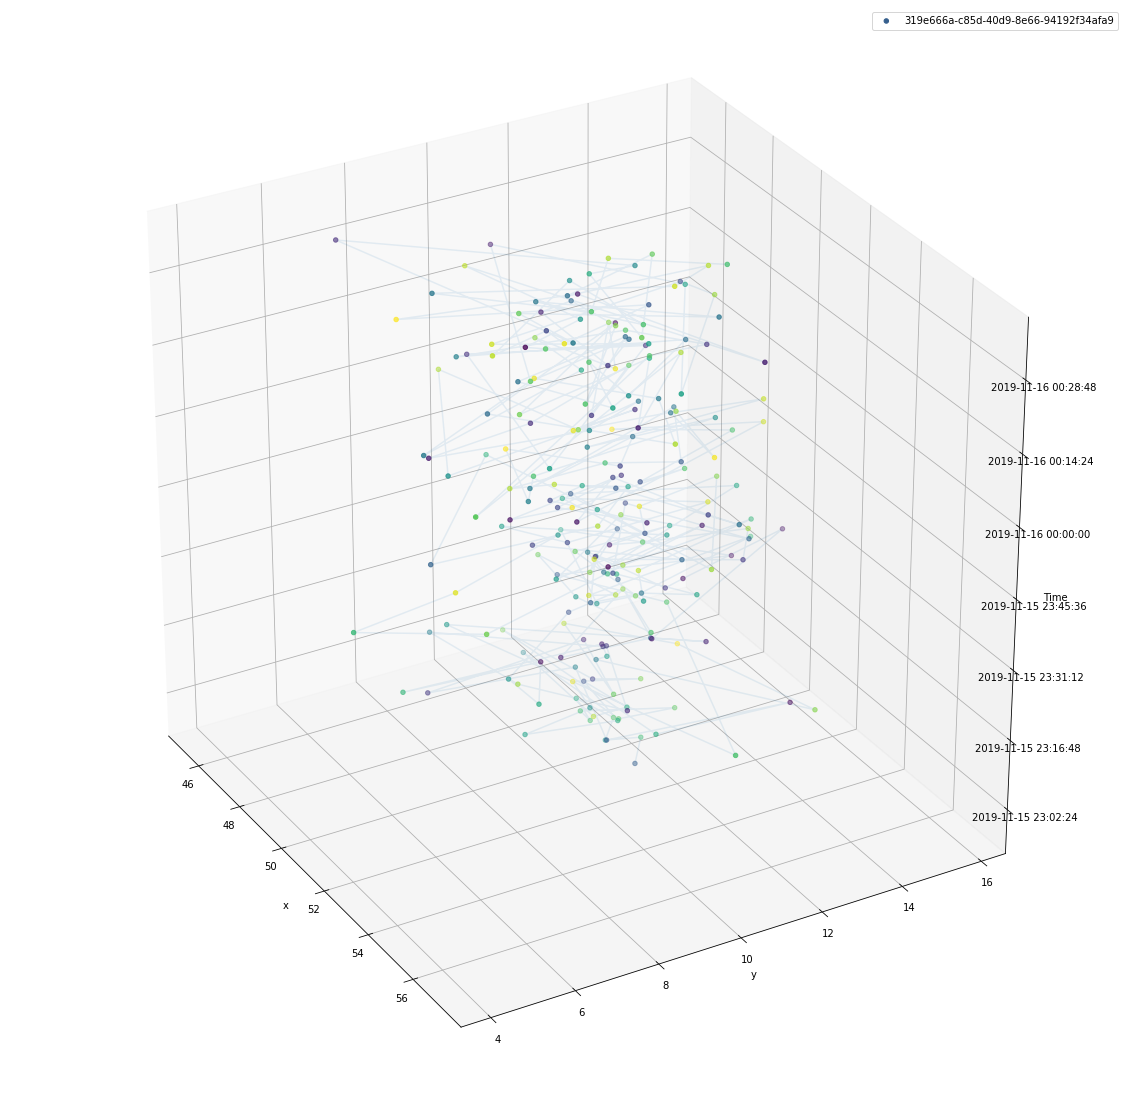

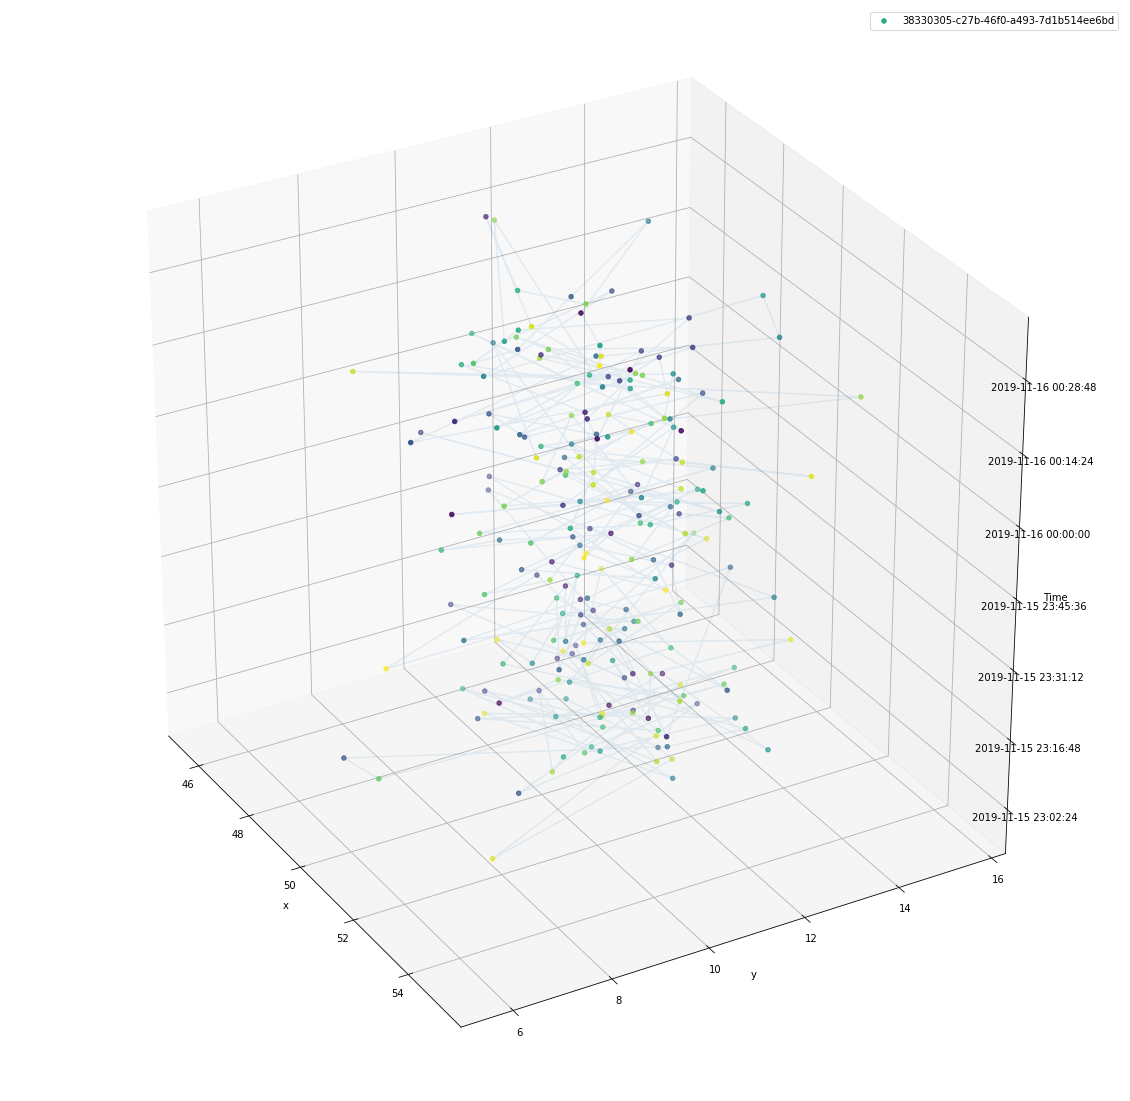

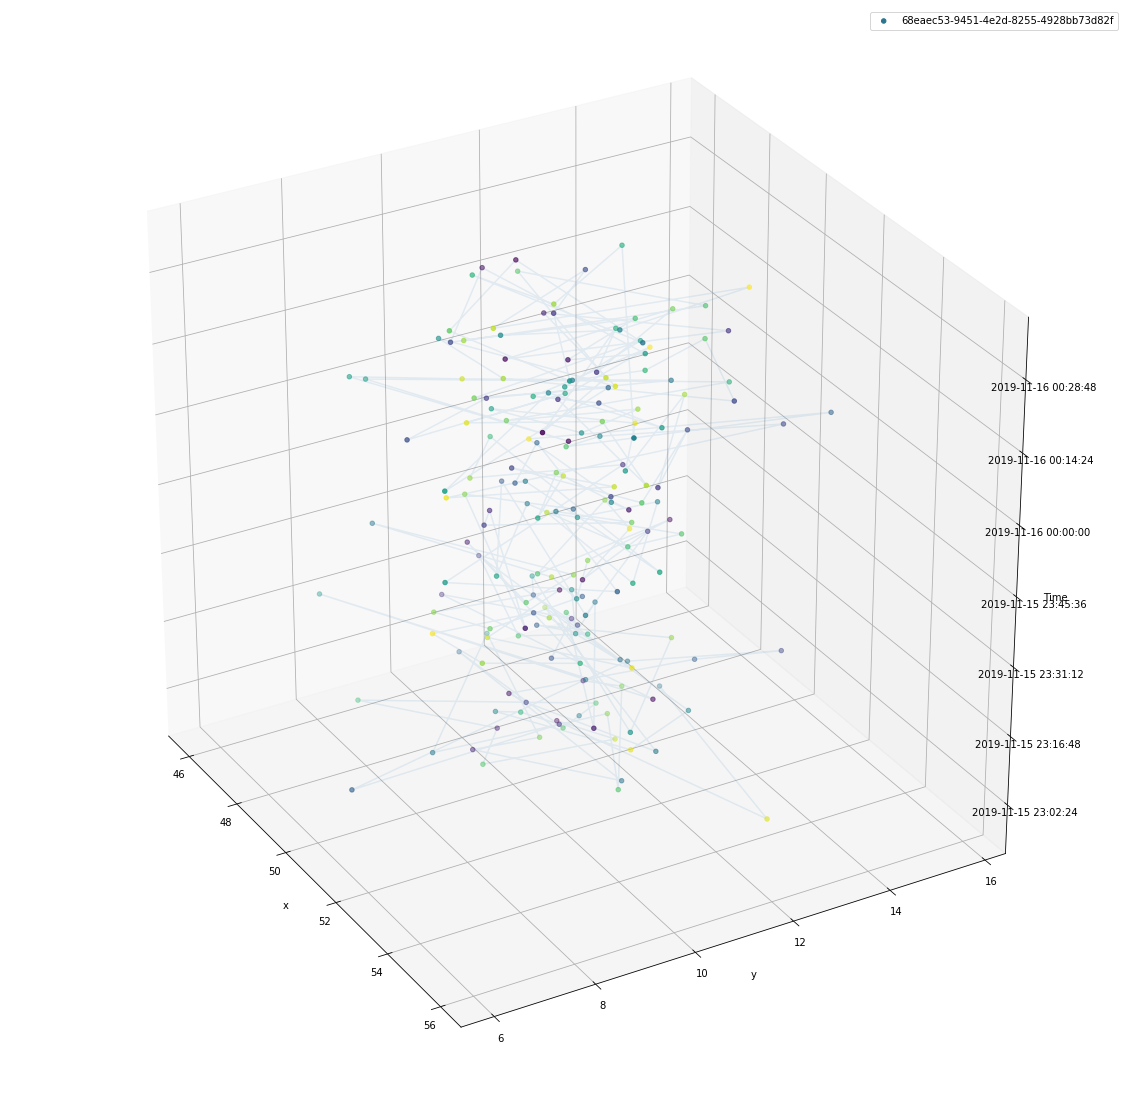

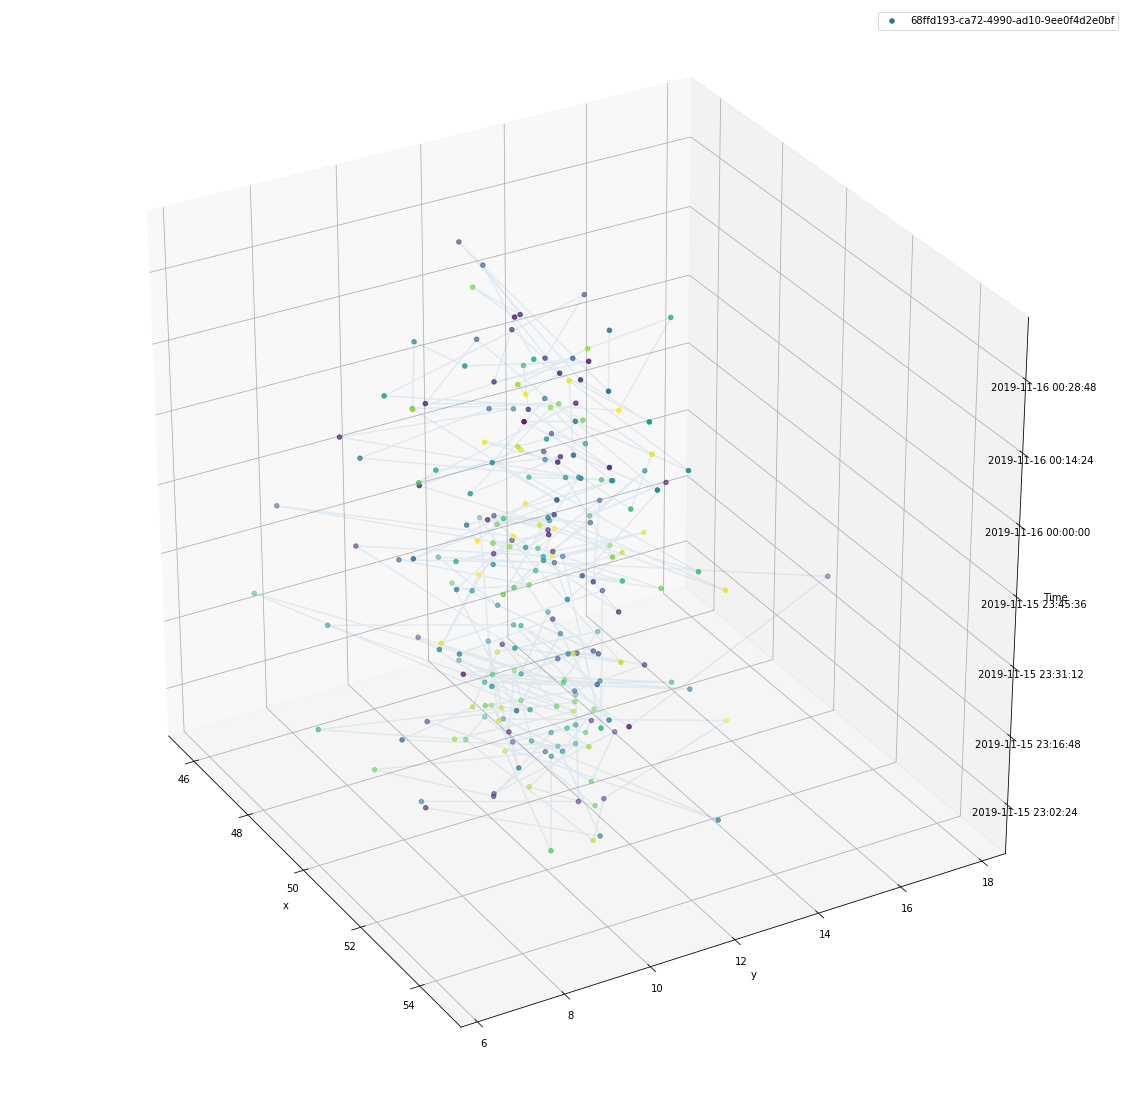

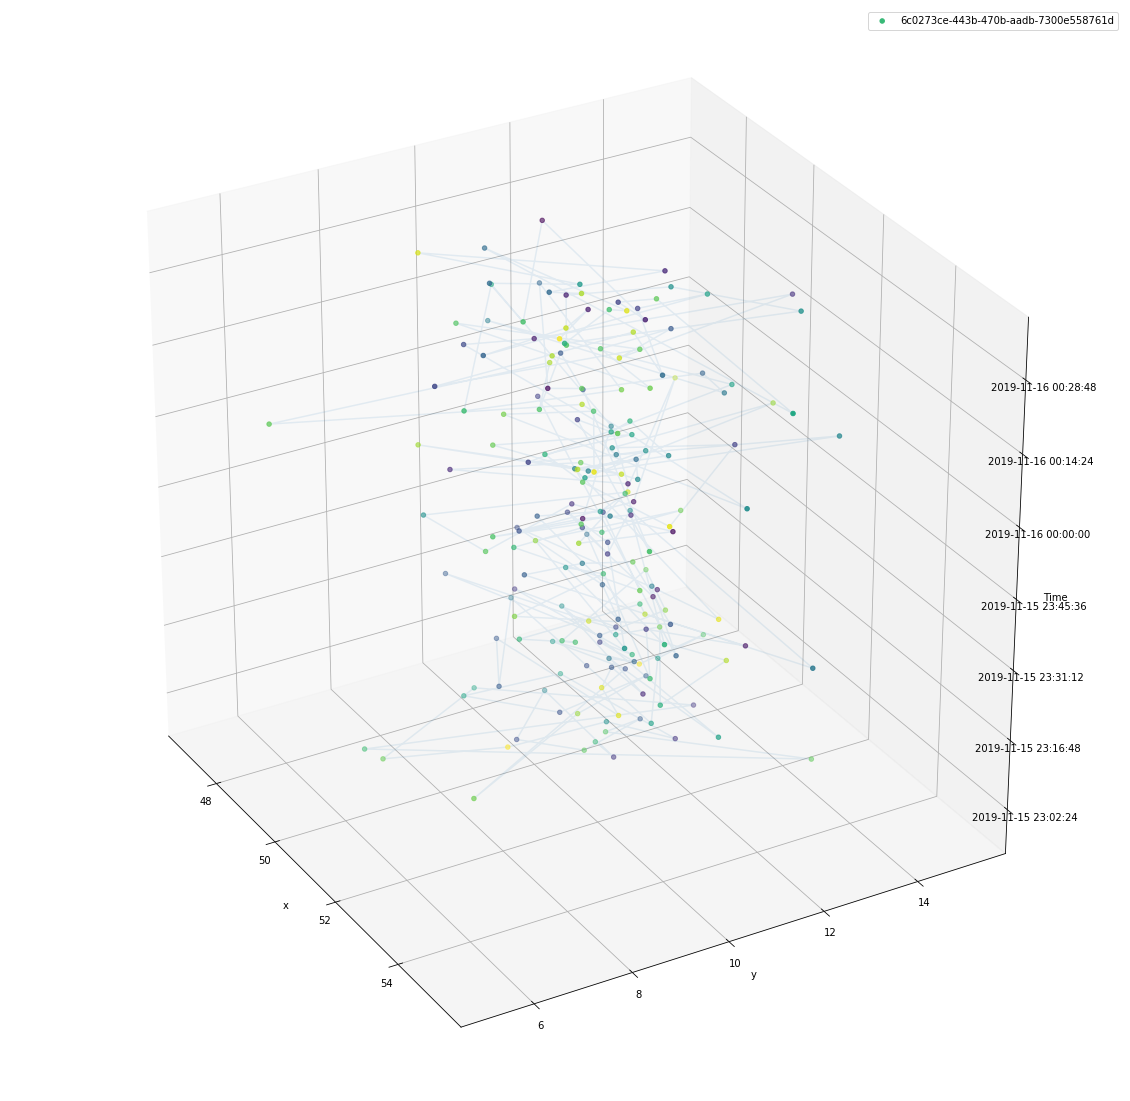

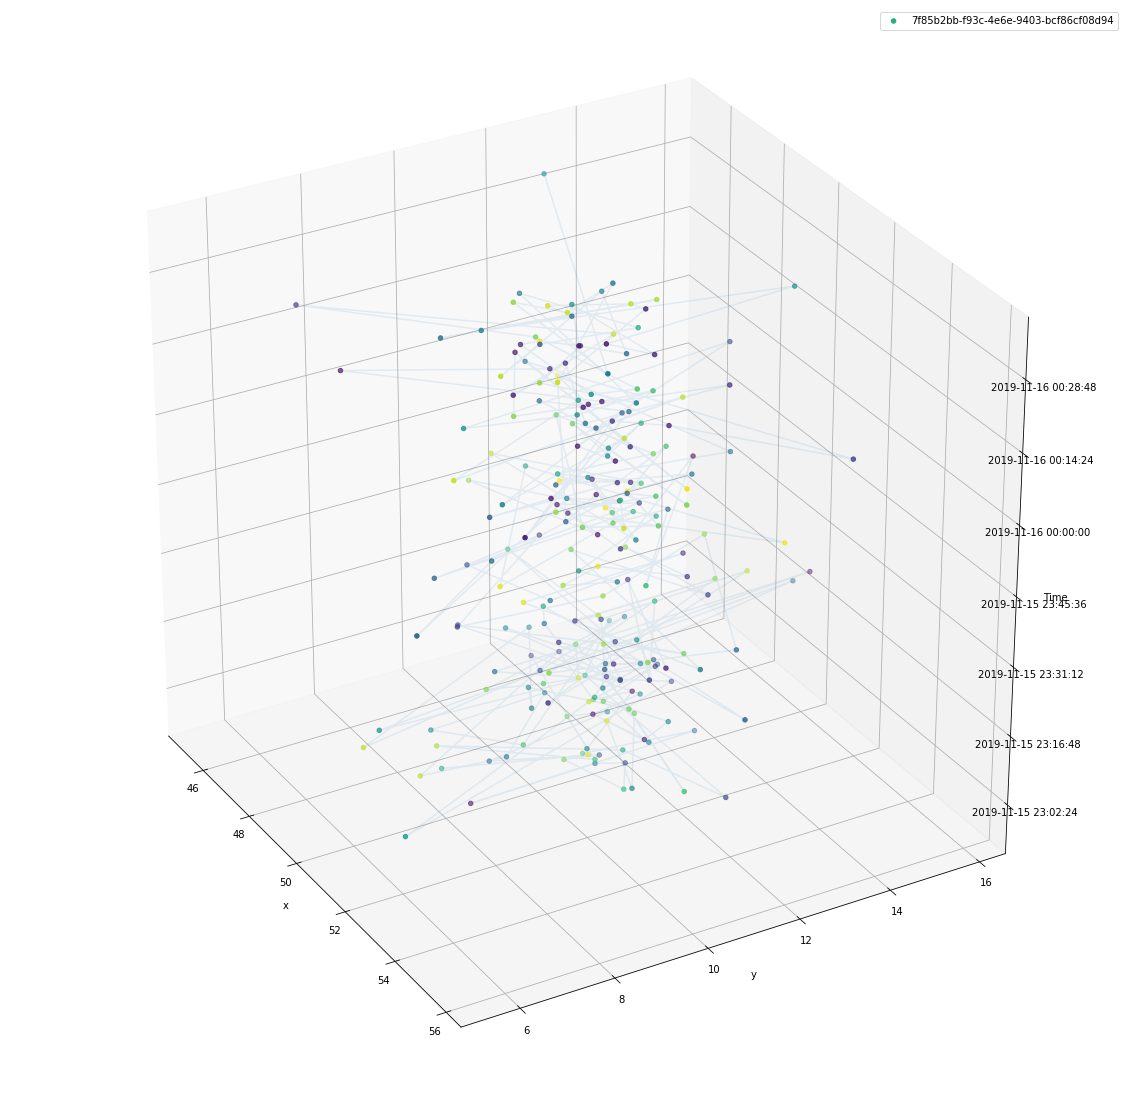

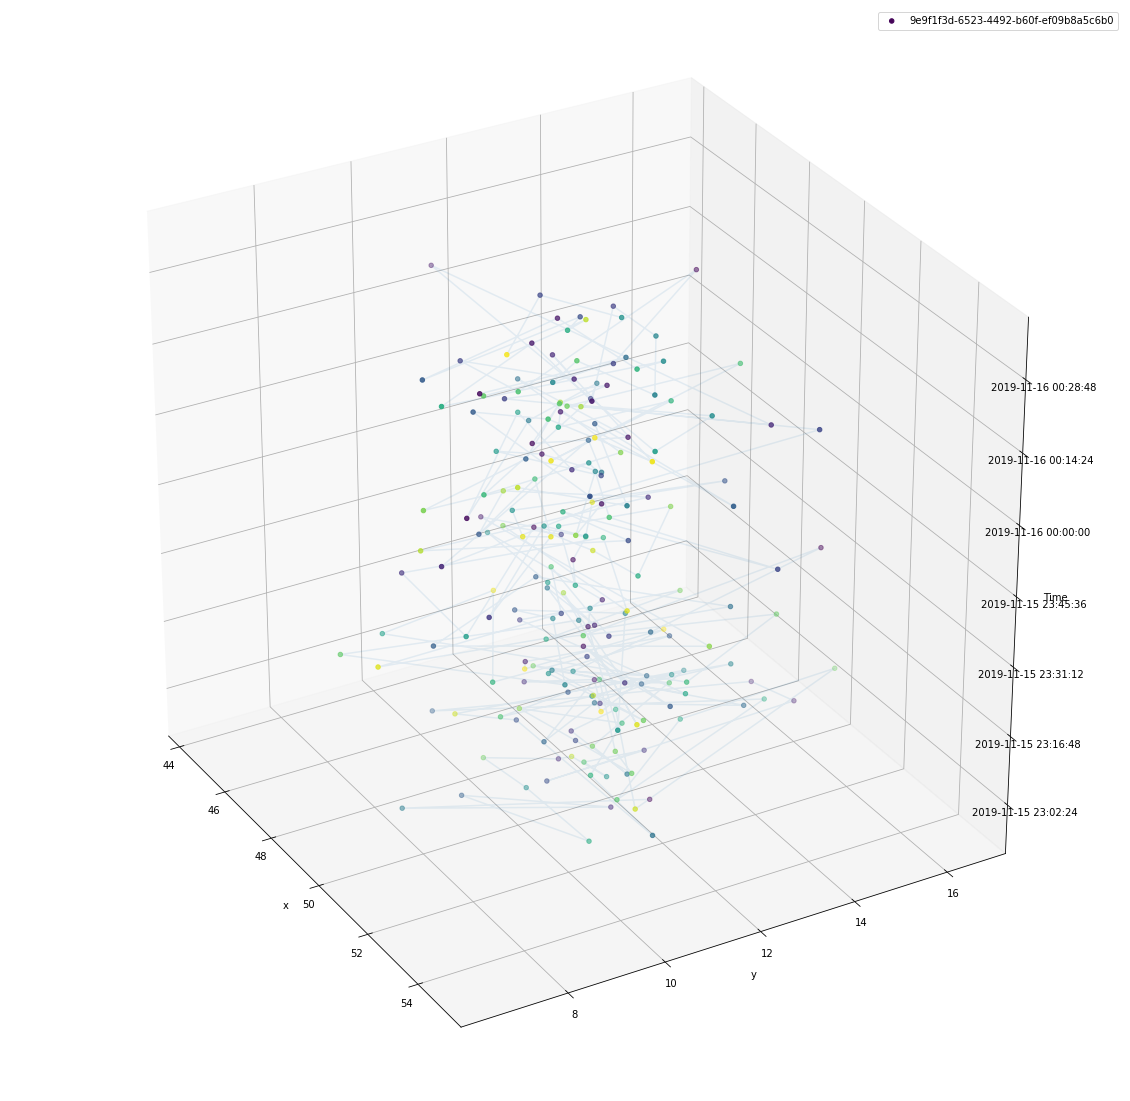

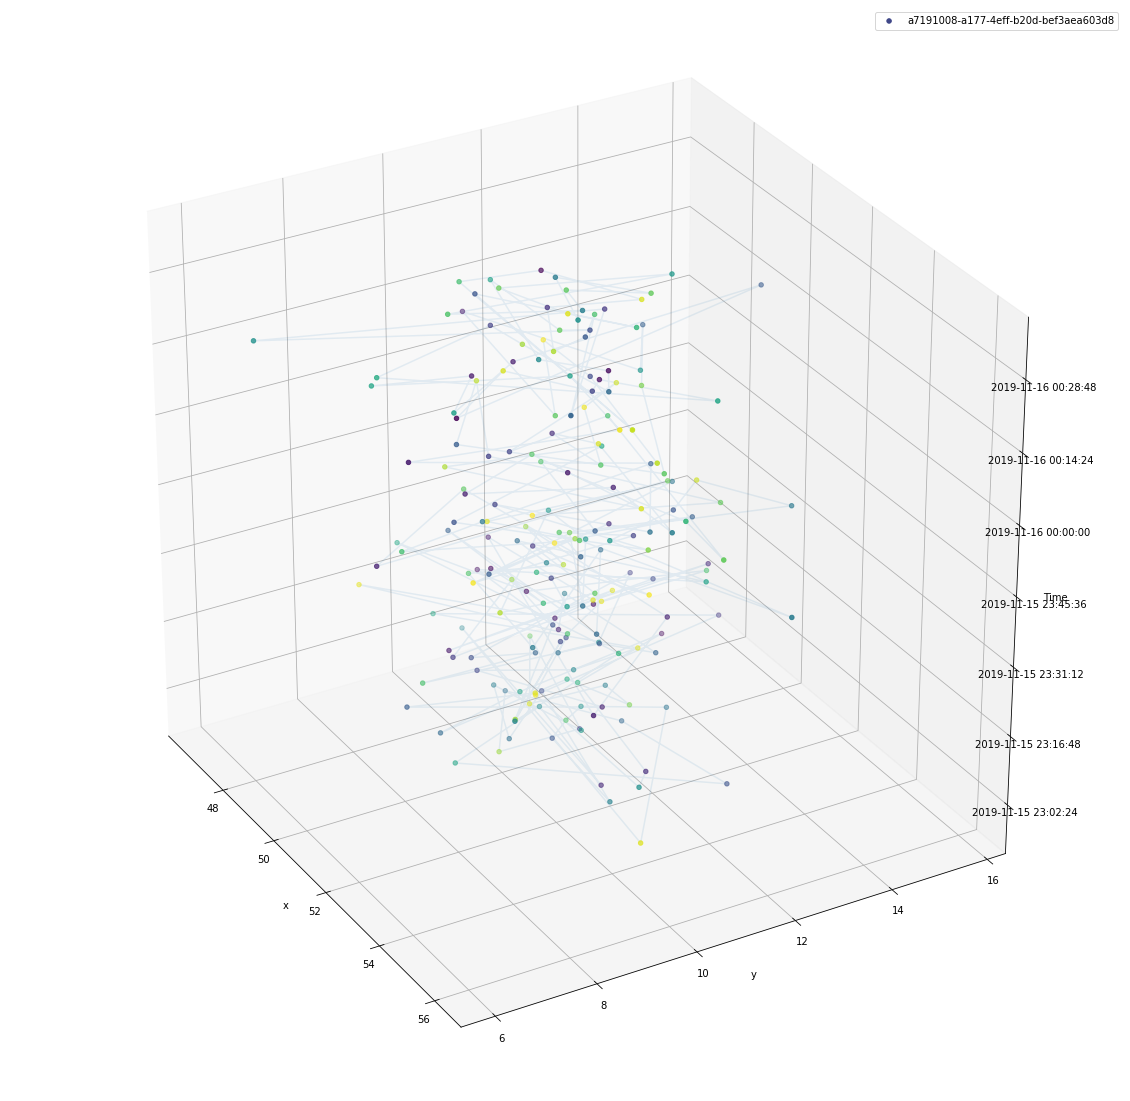

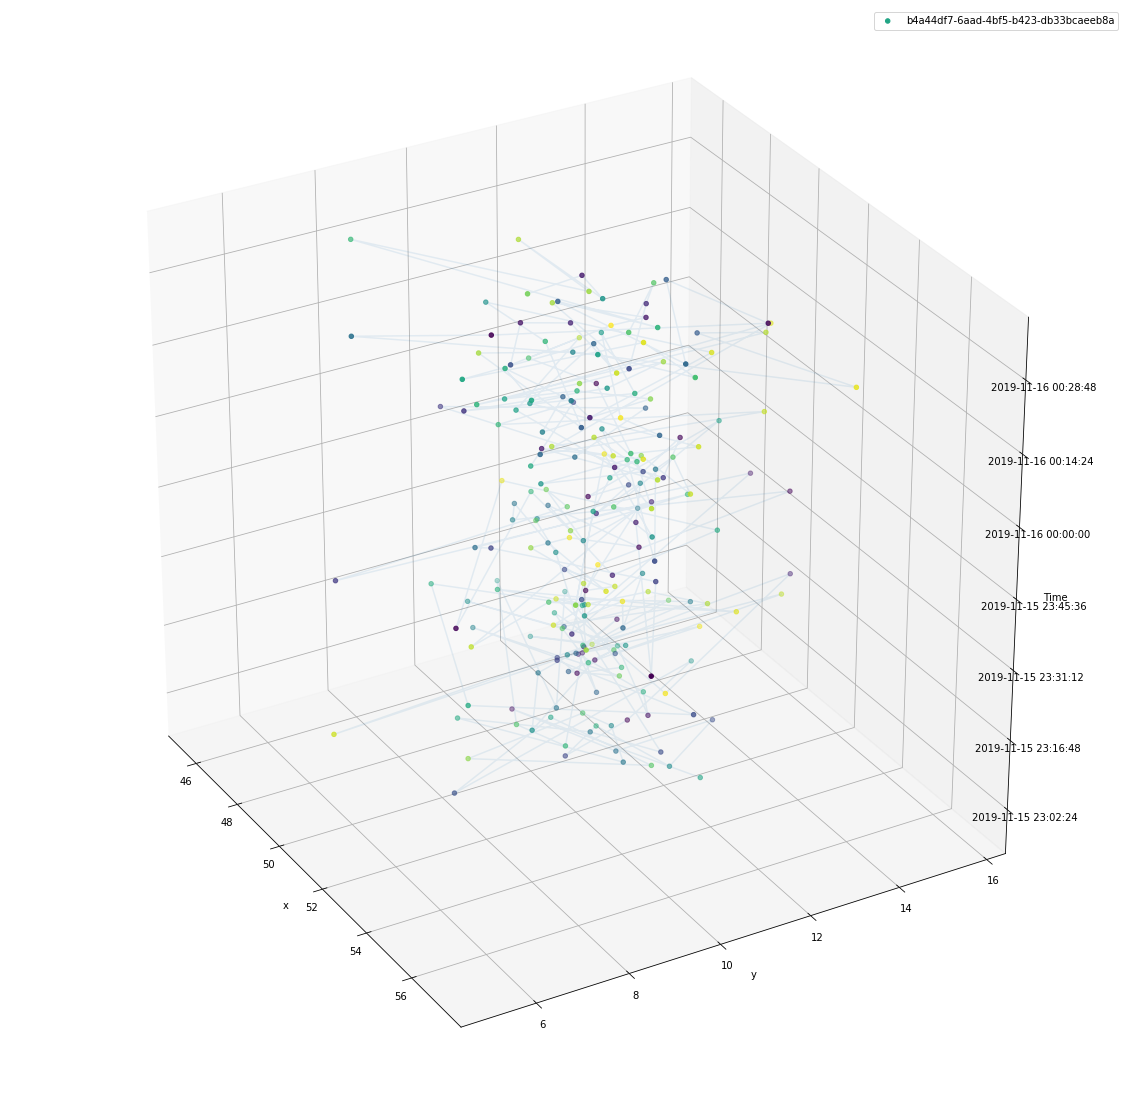

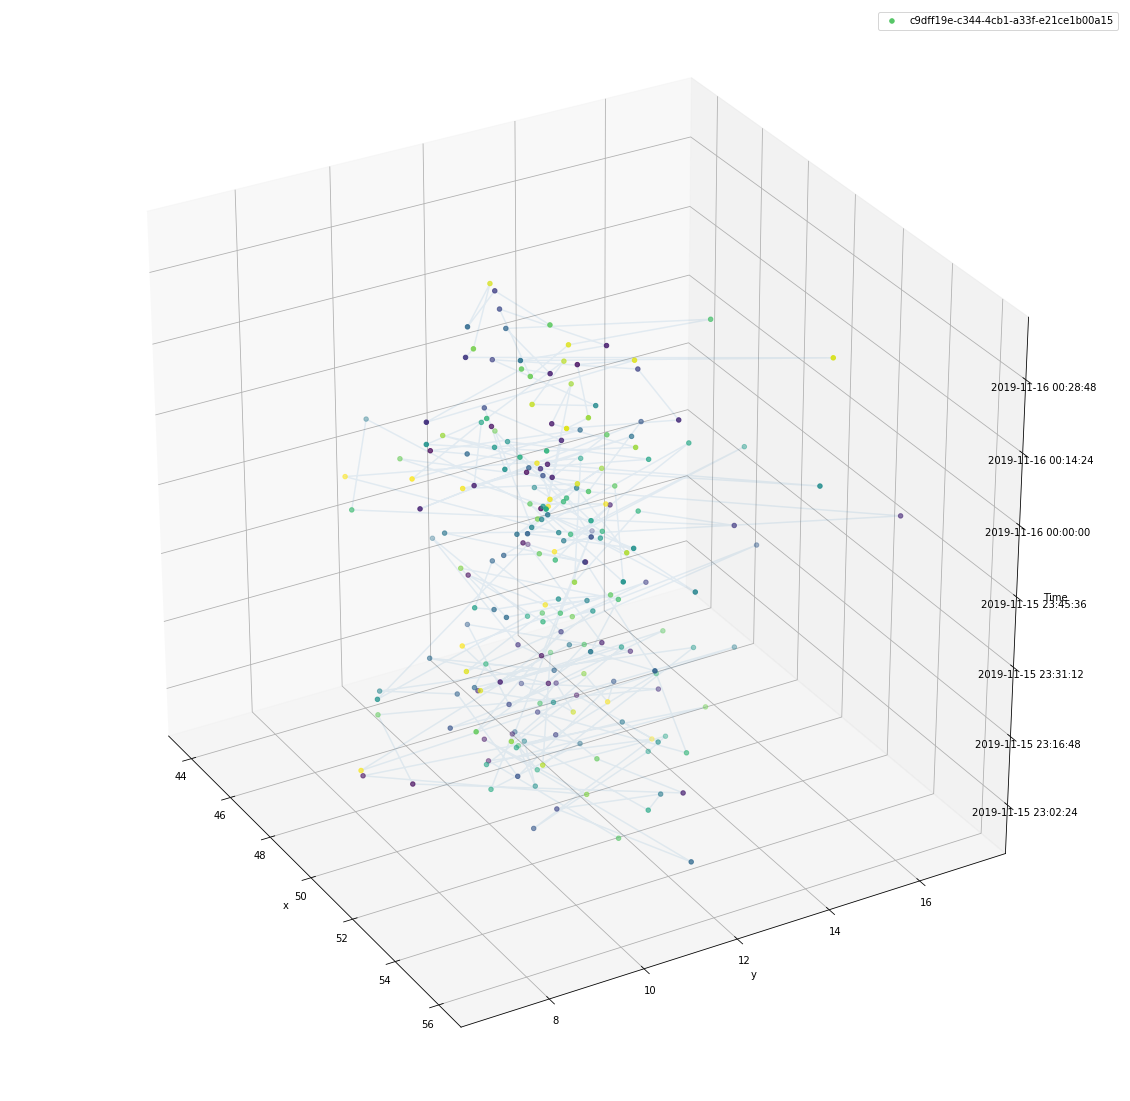

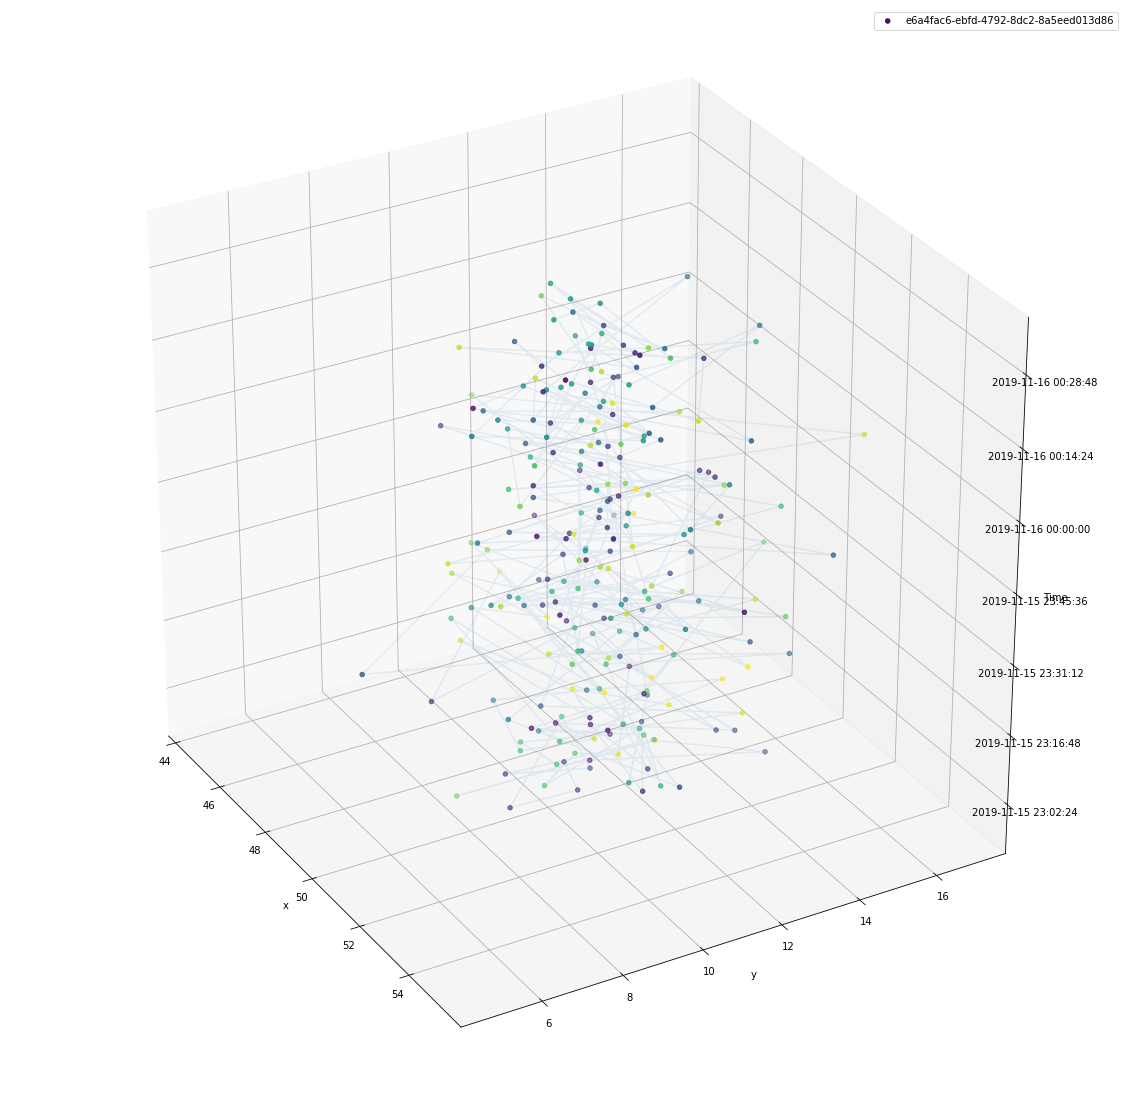

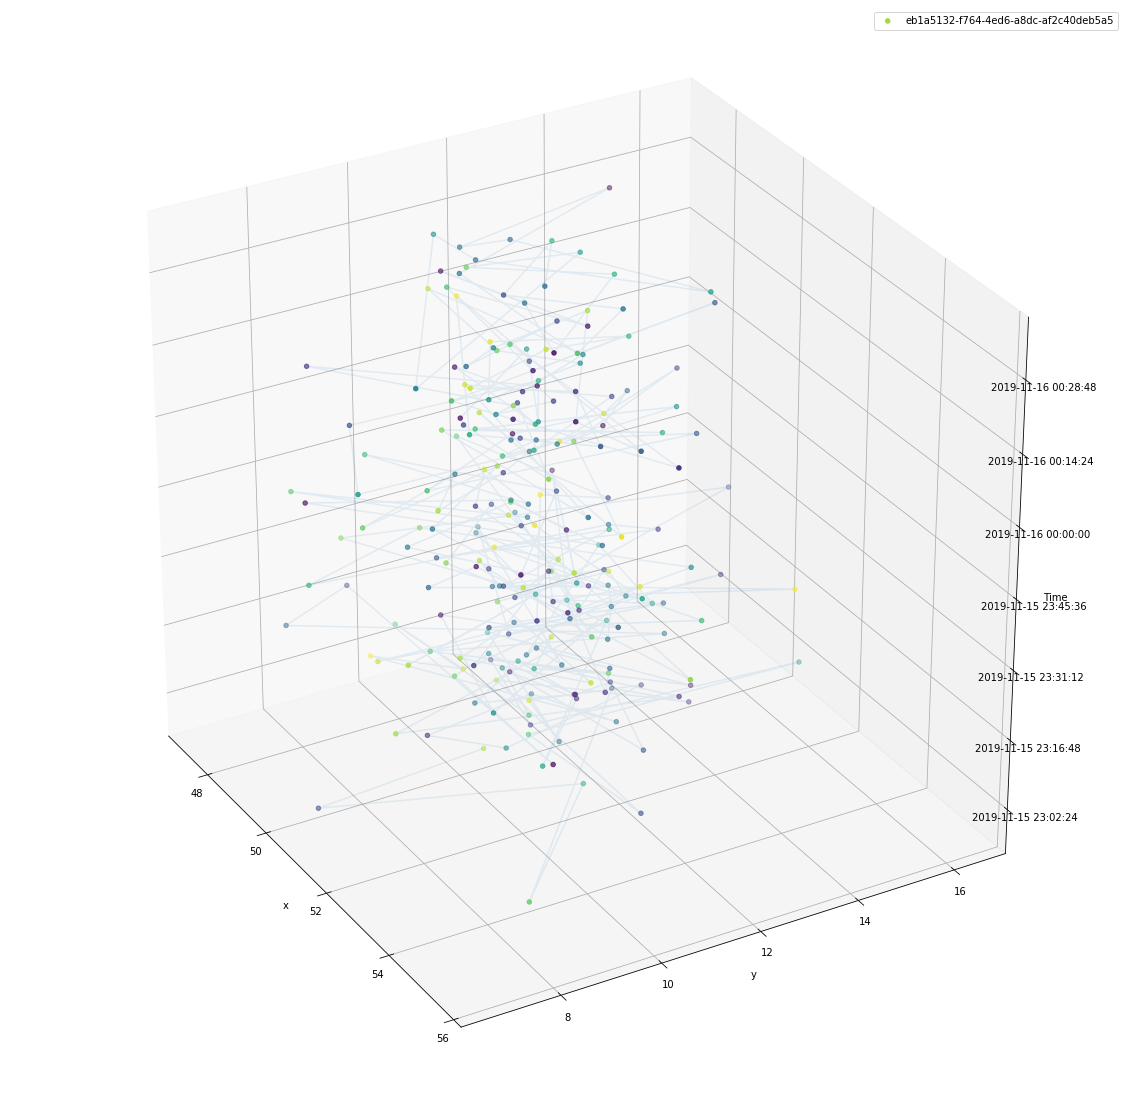

In [93]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.dates as mdates
import matplotlib.colors as colors


def plot_path(name, group):
    fig = plt.figure(figsize=(20,20))
    ax = fig.gca(projection='3d')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('Time')    
    
    ax.plot(group['longitude'].values, group['latitude'].values, mdates.date2num(group['time'].tolist()), alpha=0.1)
    ax.scatter(group['longitude'].values, group['latitude'].values, mdates.date2num(group['time'].tolist()) , label=name, marker="o",c=normalize_series(group["payload.signal.rssi"]))
    ax.zaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
    ax.view_init(30, -30)
    ax.legend()


    
for name, group in wifi_signal_quality_df.groupby("device.id"):
    
    plot_path(name,group)

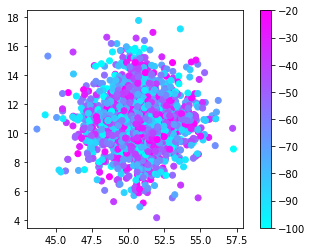

In [44]:
florence = gpd.GeoDataFrame(wifi_signal_quality_df, geometry='geometry')

florence.head()

florence.plot(column="payload.signal.rssi", cmap='cool',legend=True)

device.id
021e4c97-f61a-4983-82b5-a7b4d7bd6b97    AxesSubplot(0.125,0.125;0.775x0.755)
319e666a-c85d-40d9-8e66-94192f34afa9    AxesSubplot(0.125,0.125;0.775x0.755)
38330305-c27b-46f0-a493-7d1b514ee6bd    AxesSubplot(0.125,0.125;0.775x0.755)
68eaec53-9451-4e2d-8255-4928bb73d82f    AxesSubplot(0.125,0.125;0.775x0.755)
68ffd193-ca72-4990-ad10-9ee0f4d2e0bf    AxesSubplot(0.125,0.125;0.775x0.755)
6c0273ce-443b-470b-aadb-7300e558761d    AxesSubplot(0.125,0.125;0.775x0.755)
7f85b2bb-f93c-4e6e-9403-bcf86cf08d94    AxesSubplot(0.125,0.125;0.775x0.755)
9e9f1f3d-6523-4492-b60f-ef09b8a5c6b0    AxesSubplot(0.125,0.125;0.775x0.755)
a7191008-a177-4eff-b20d-bef3aea603d8    AxesSubplot(0.125,0.125;0.775x0.755)
b4a44df7-6aad-4bf5-b423-db33bcaeeb8a    AxesSubplot(0.125,0.125;0.775x0.755)
c9dff19e-c344-4cb1-a33f-e21ce1b00a15    AxesSubplot(0.125,0.125;0.775x0.755)
e6a4fac6-ebfd-4792-8dc2-8a5eed013d86    AxesSubplot(0.125,0.125;0.775x0.755)
eb1a5132-f764-4ed6-a8dc-af2c40deb5a5    AxesSubplot(0.125,0.125;0.

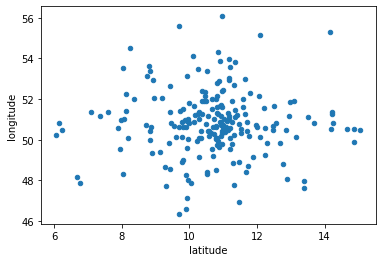

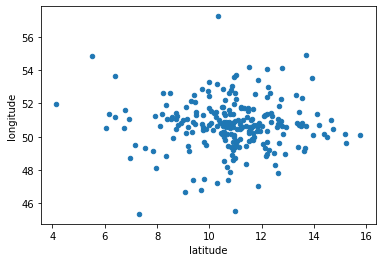

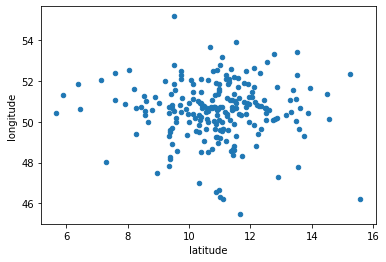

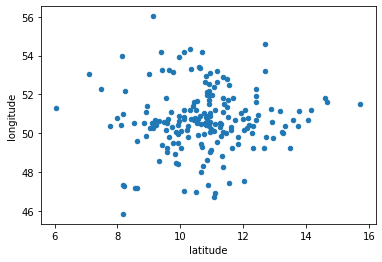

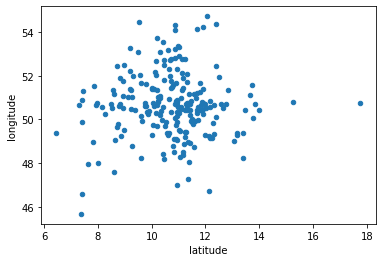

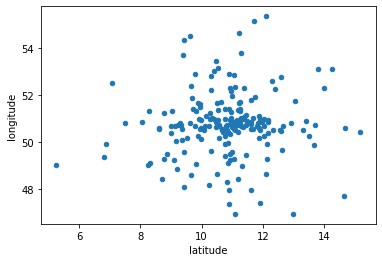

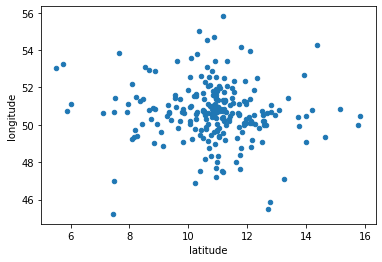

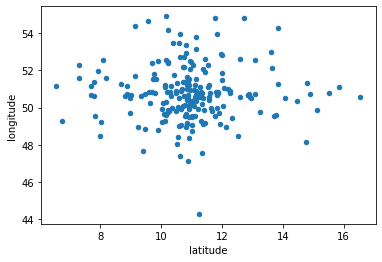

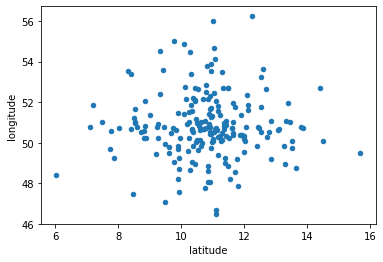

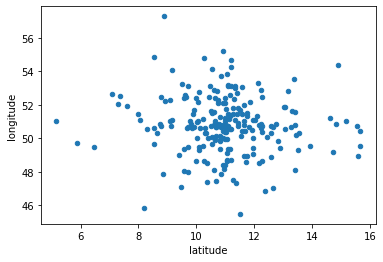

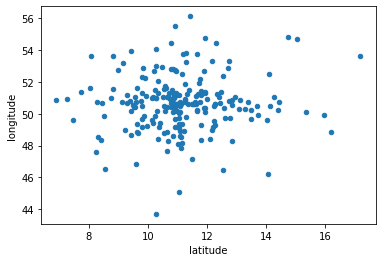

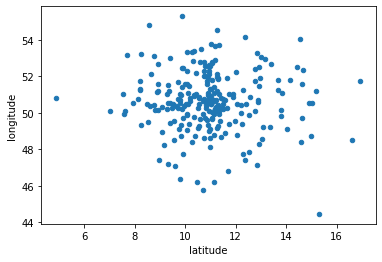

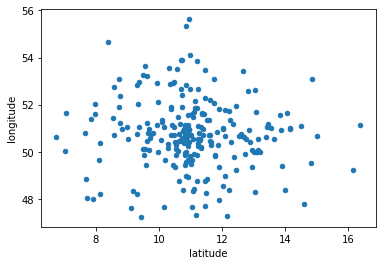

In [27]:
wifi_signal_quality_df.sort_values("time").groupby("device.id").plot(kind='scatter', x="latitude", y='longitude')

## GPS locations by hands

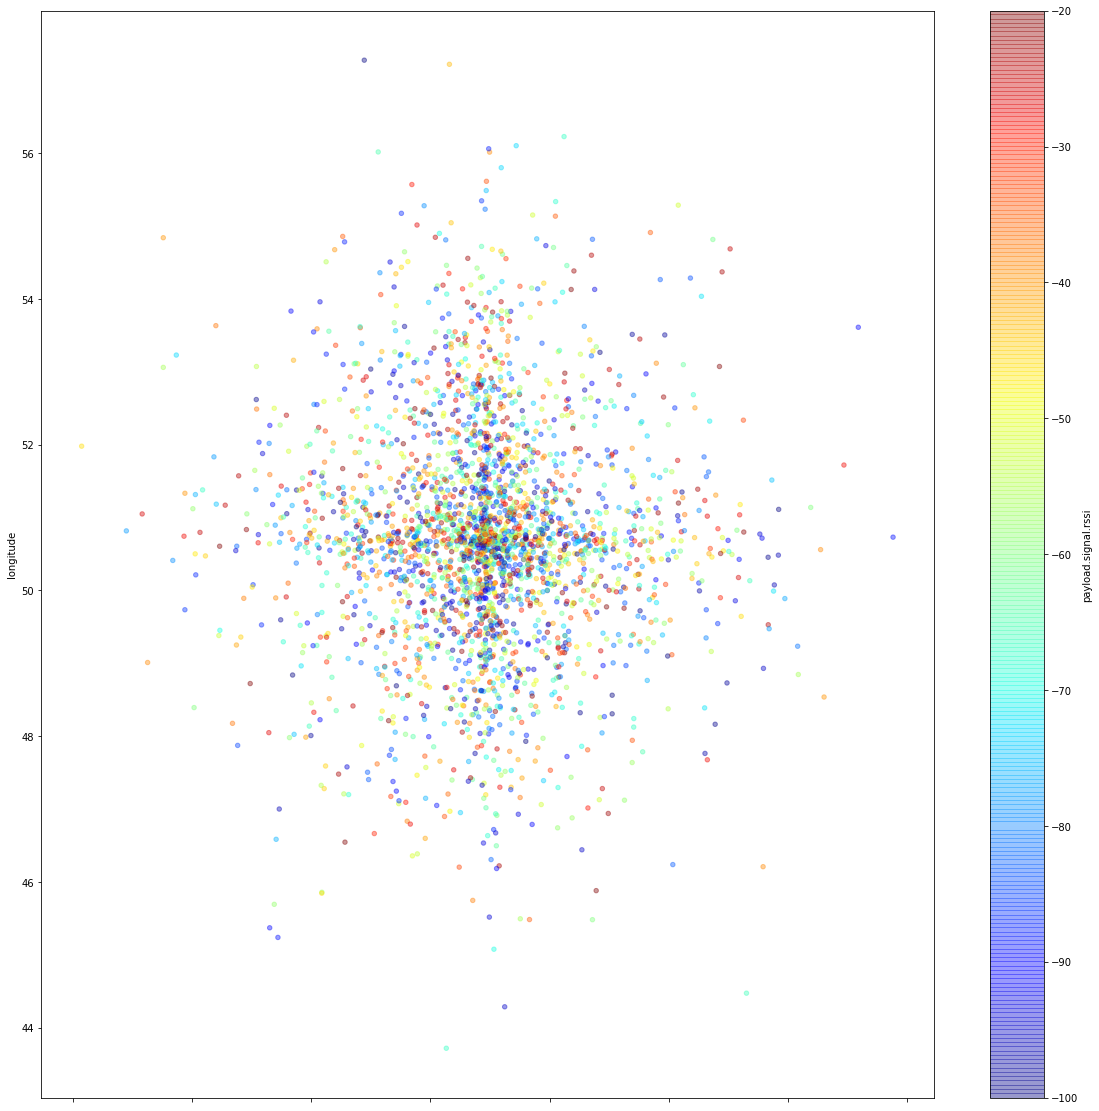

In [15]:
wifi_signal_quality_df.plot(kind="scatter", y="longitude", x="latitude", c="payload.signal.rssi", cmap=plt.get_cmap("jet"), alpha=0.4, figsize=(20,20))

## GPS Positions in the World

In [16]:
import descartes
import geopandas as gpd
from shapely.geometry import Point,Polygon

In [17]:
geometry = [Point(xy) for xy in zip(wifi_signal_quality_df["longitude"], wifi_signal_quality_df['latitude'])]

In [18]:
geo_df = gpd.GeoDataFrame(wifi_signal_quality_df,
      geometry = geometry)

geo_df.head()

time  longitude   latitude  \
0 2019-11-15 22:59:00  49.265486  13.499028   
1 2019-11-15 22:59:00  51.502581  11.992715   
2 2019-11-15 22:59:00  49.377491   8.248235   
3 2019-11-15 22:59:00  53.230136  11.287466   
4 2019-11-15 22:59:00  48.242247  13.412806   

                              device.id  payload.signal.rssi payload.ssid  \
0  68eaec53-9451-4e2d-8255-4928bb73d82f                  -69        AP #4   
1  9e9f1f3d-6523-4492-b60f-ef09b8a5c6b0                  -99        AP #4   
2  7f85b2bb-f93c-4e6e-9403-bcf86cf08d94                  -51        AP #8   
3  c9dff19e-c344-4cb1-a33f-e21ce1b00a15                  -41        AP #2   
4  68ffd193-ca72-4990-ad10-9ee0f4d2e0bf                  -68        AP #6   

                    geometry  
0  POINT (49.26549 13.49903)  
1  POINT (51.50258 11.99272)  
2   POINT (49.37749 8.24823)  
3  POINT (53.23014 11.28747)  
4  POINT (48.24225 13.41281)

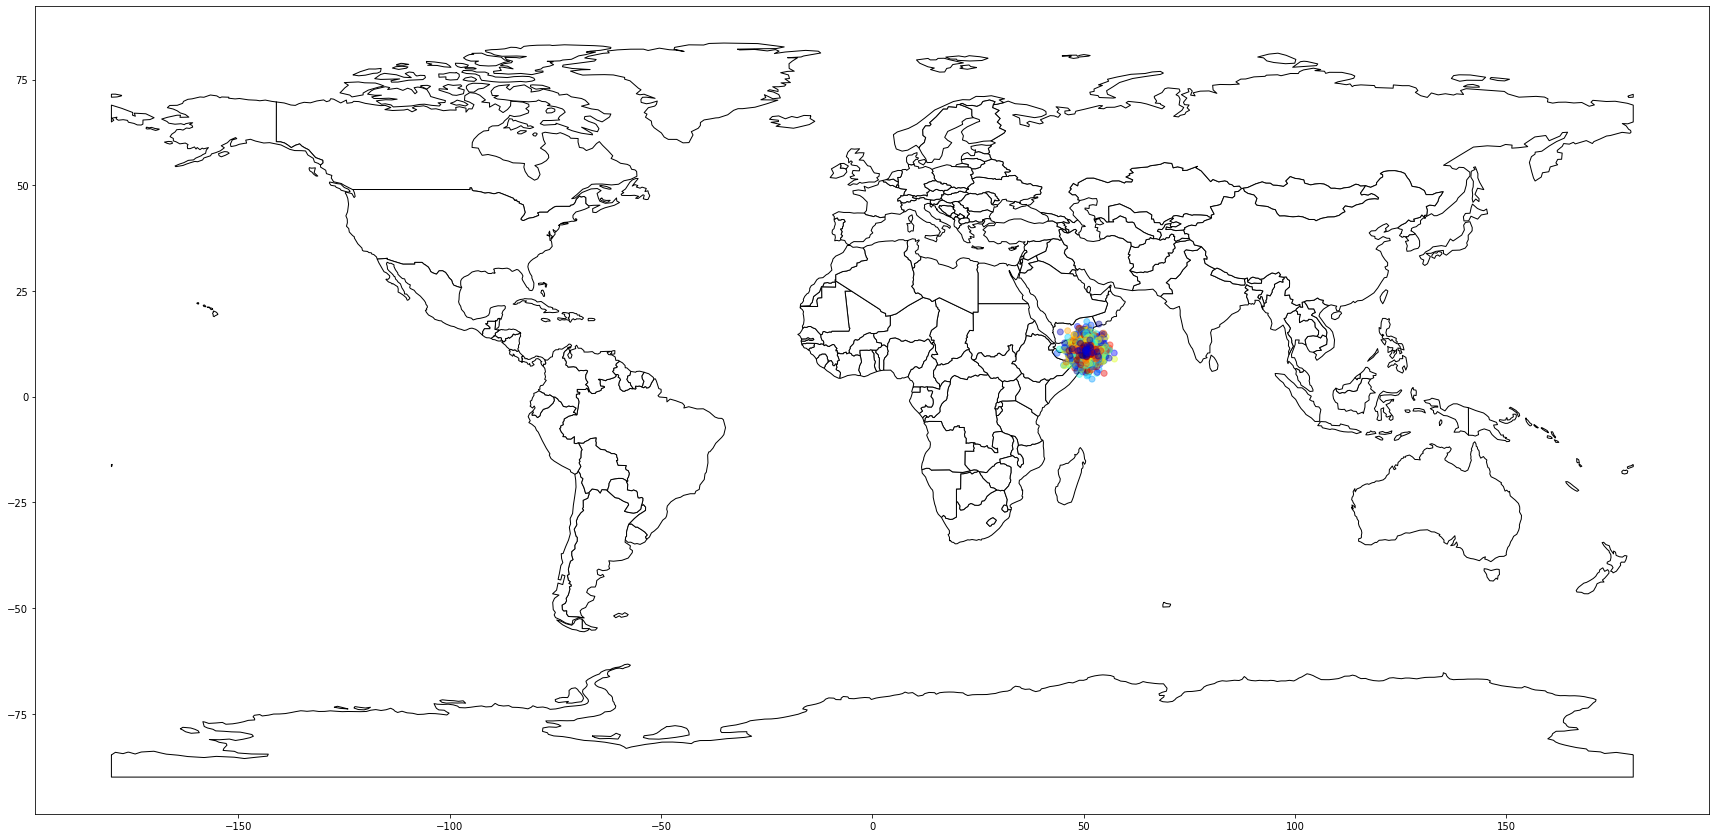

In [19]:
# https://www.bigendiandata.com/2017-06-27-Mapping_in_Jupyter/
# https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


base = world.plot(color='white', edgecolor='black', figsize=(30,30),)


geo_df.plot(label="rssi",
    c="payload.signal.rssi", cmap=plt.get_cmap("jet"),
    alpha=0.4, figsize=(30,30), ax=base);